# 0 环境配置

In [1]:
import numpy as np
import os
import sys, time
sys.path.append('../')

import matplotlib.pyplot as plt
%matplotlib inline

from model.loss import change_mask_loss
from model.metric import count_accuracy, accuracy_mask
from keras.applications.xception import preprocess_input
from keras.callbacks import Callback, EarlyStopping
from model.DepthwiseConv2D import DepthwiseConv2D
from model.switchnorm import SwitchNormalization
from keras.utils import multi_gpu_model
from keras.optimizers import *
from keras.models import load_model
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from dataload.data_generator_Aim_Amp_Bim__Bmp_count_pro import *
from model.core_model import model_v6 as my_model

gpus = 2
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.95
session = tf.Session(config=config)


/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1 预设参数

In [2]:
base_project = os.path.abspath('../')
data_dir    = os.path.join(base_project, 'dataspace')
model_name = 'model_v6'
image_size = (512, 512)
mask_size  = (63, 63)

# 2 数据生成

In [3]:
threshold = 0
heatmap_height = mask_size[0]
heatmap_width  = mask_size[1]

train_batch_size = 32
valid_batch_size = 32
test_batch_size  = 32

train_gen = MyImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=6,
    channel_shift_range=15,
    zoom_range=(.9, 1.1),
    horizontal_flip=True
)

gen = MyImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_gen.myflow_from_directory(os.path.join(data_dir, 'train'),
                                                  target_size       = image_size,
                                                  x_threshold       = threshold,
                                                  y_threshold       = threshold,
                                                  dataset           = 'train',
                                                  return_path       = True,
                                                  heatmap_height    = heatmap_height,
                                                  heatmap_width     = heatmap_width,
                                                  batch_size        = train_batch_size)

valid_generator = gen.myflow_from_directory(os.path.join(data_dir, 'valid'), 
                                           target_size       = image_size,
                                           x_threshold       = threshold,
                                           y_threshold       = threshold,
                                           dataset           = 'test',
                                           return_path       = True,
                                           heatmap_height    = heatmap_height,
                                           heatmap_width     = heatmap_width,
                                           batch_size        = valid_batch_size)

test_generator = gen.myflow_from_directory(os.path.join(data_dir, 'test'), 
                                           target_size       = image_size,
                                           x_threshold       = threshold,
                                           y_threshold       = threshold,
                                           dataset           = 'test',
                                           return_path       = True,
                                           heatmap_height    = heatmap_height,
                                           heatmap_width     = heatmap_width,
                                           batch_size        = valid_batch_size)
train_samples_epoch = train_generator.data_num
print("samples_train = {}".format(train_samples_epoch))

steps_train = len(train_generator)
print("steps_train = {}".format(steps_train))

valid_samples_epoch = valid_generator.data_num
print("samples_valid = {}".format(valid_samples_epoch))

steps_valid = len(valid_generator)
print("steps_valid = {}".format(steps_valid))

test_samples_epoch = test_generator.data_num
print("samples_test = {}".format(test_samples_epoch))

steps_test = len(test_generator)
print("steps_test = {}".format(steps_test))

# 3 搭建模型

Found 58885 image pairs.
Found 17608 image pairs.
samples_train_epoch = 58885
steps_train = 1841
samples_valid_epoch = 17608
steps_valid = 551


# 3 搭建模型

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 63, 63, 1)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
mp_conv_1 (Conv2D)              (None, 63, 63, 16)   144         input_3[0][0]                    
__________________________________________________________________________________________________
vision_mod

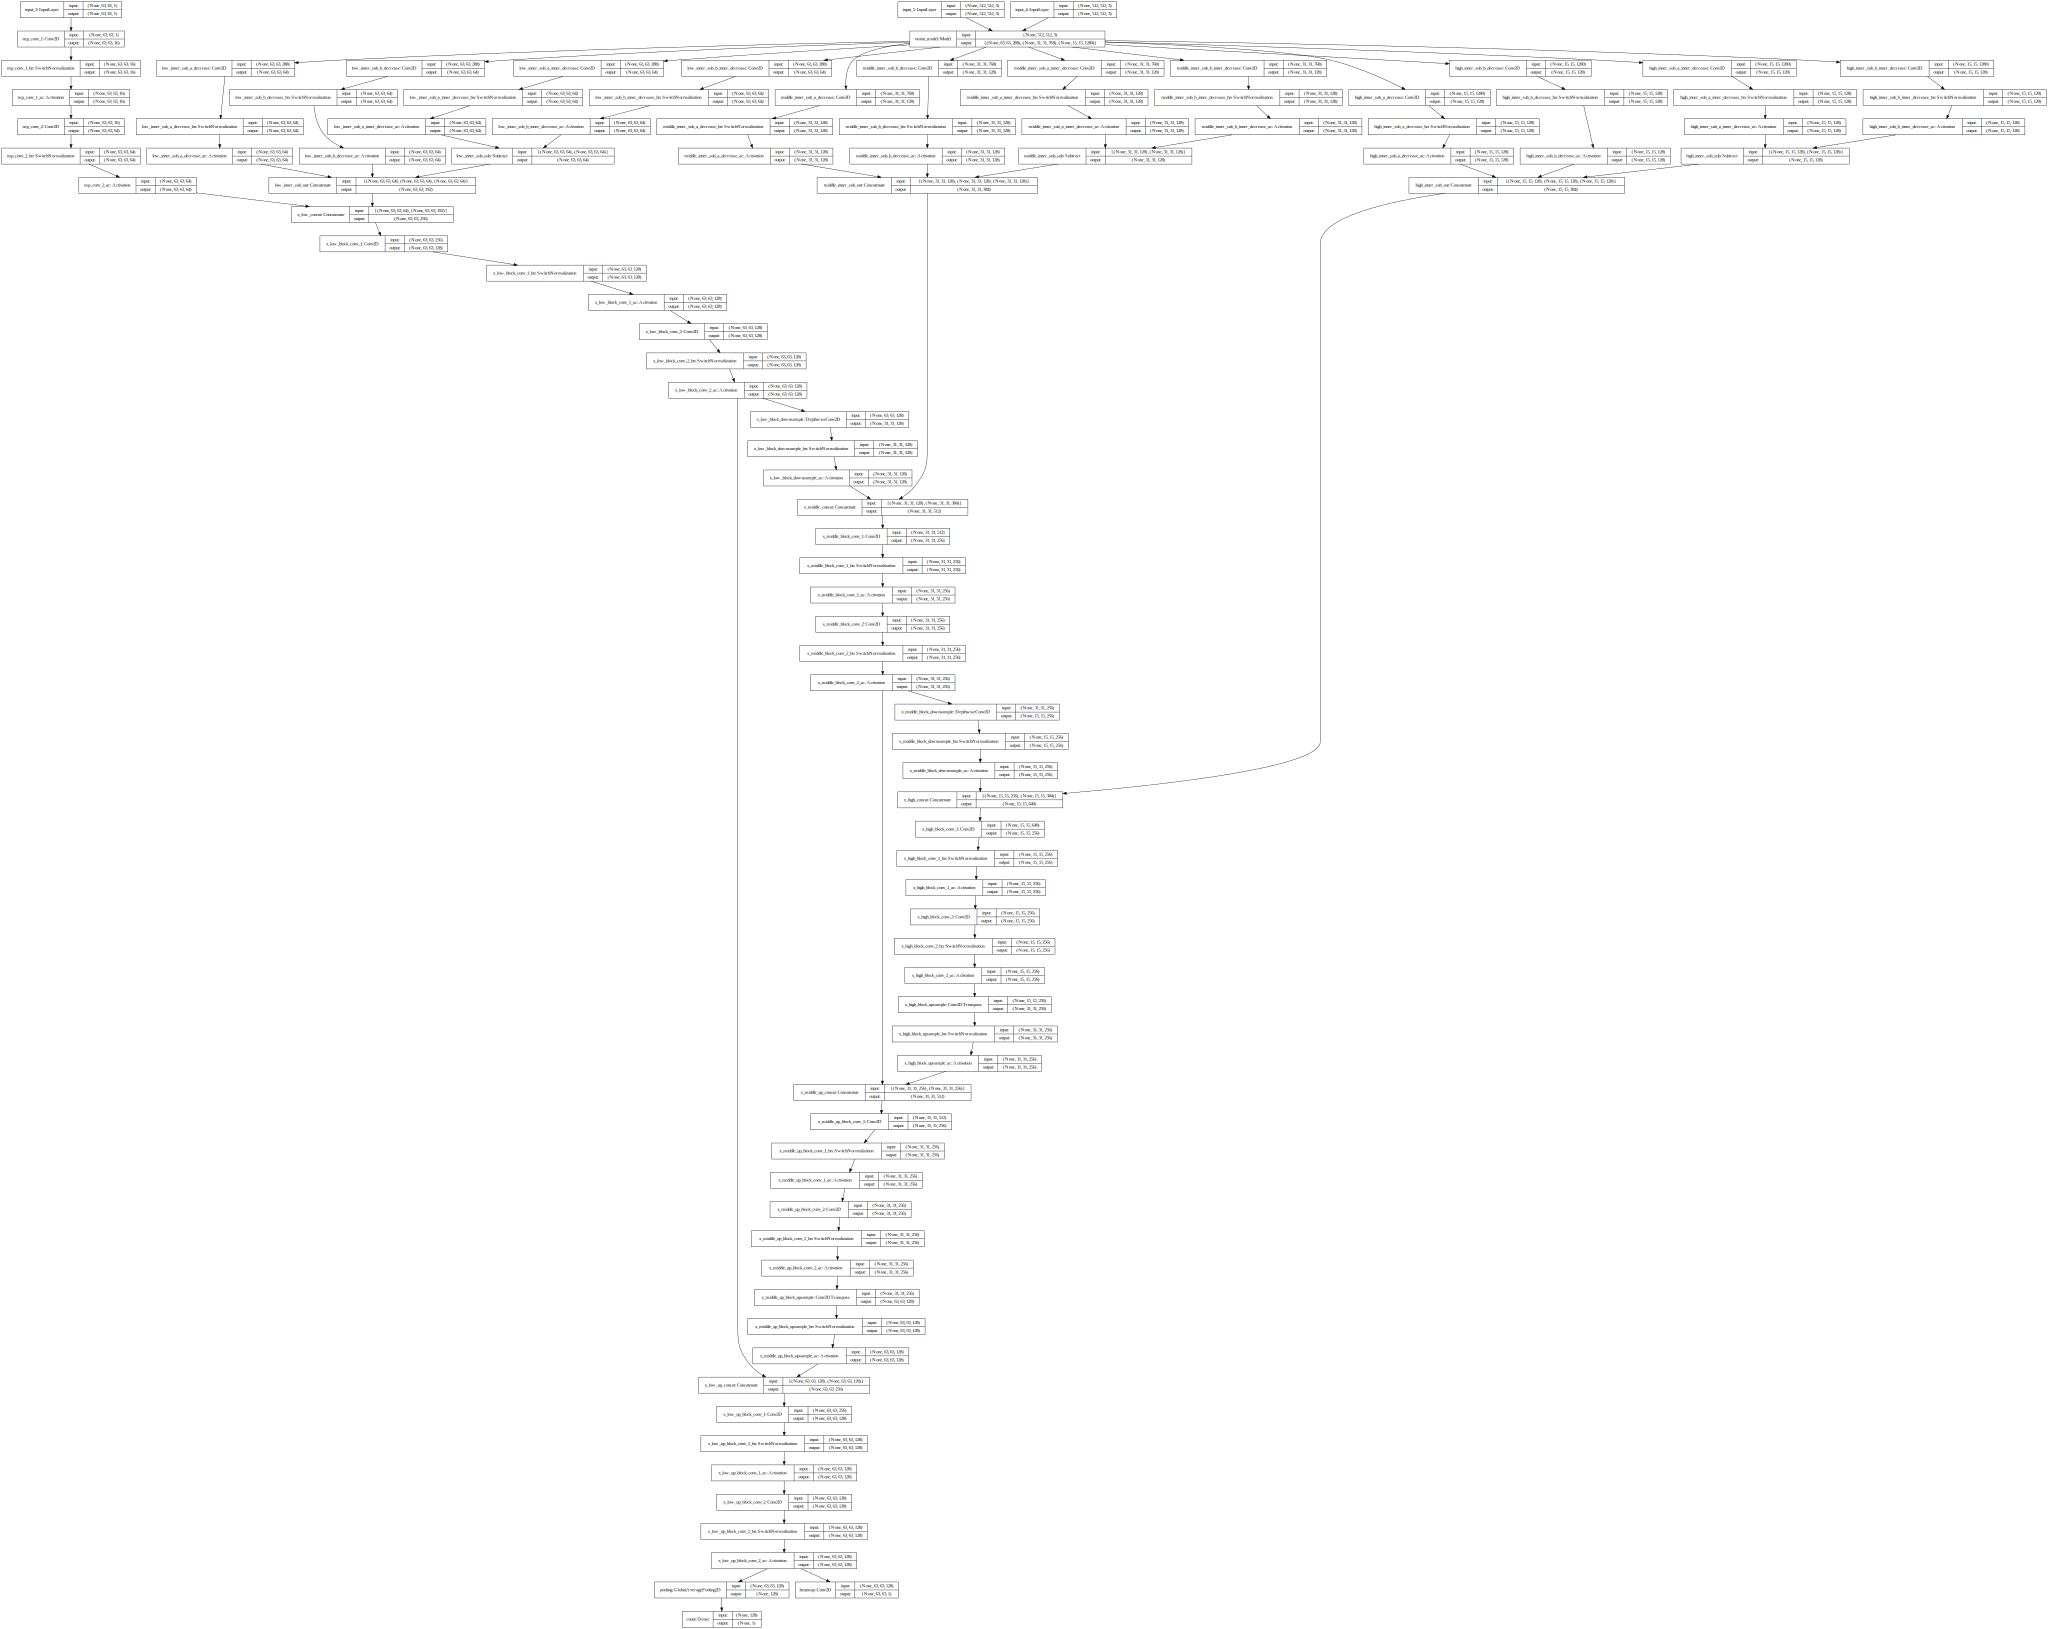

In [4]:
model = my_model()
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 4 训练模型

In [56]:
model_path = os.path.join(base_project,  'checkpoints/' + model_name)

if not os.path.exists(model_path):
    os.makedirs(model_path)

class MyModelCheckpoint(Callback):
    def __init__(self, model, path, init_loss=np.inf, init_acc=-1):
        self.mymodel = model
        self.path = path
        self.best_loss = init_loss
        self.best_acc = init_acc
        
    def on_epoch_end(self, epoch, logs=None):
        stamp = time.strftime('%Y%m%d%H%M',time.localtime(time.time()))

        val_loss = logs['val_loss']
        val_acc = logs['val_count__count_accuracy']

        _model = '{}_{}_{:.4f}_{:.4f}{}'.format(model_name, stamp, val_loss, val_acc, '_model.h5')
        model_path = os.path.join(self.path, _model)
        short_name = '{}.h5'.format(model_name)
        
        if val_loss < self.best_loss:
            print("\nValidation loss decreased from {:.4f} to {:.4f}, saving model to {}".format(self.best_loss, val_loss, _model))
            self.mymodel.save(os.path.join(self.path, short_name), overwrite=True)
            self.mymodel.save(model_path, overwrite=True)
            self.best_loss = val_loss
            if val_acc > self.best_acc:
                self.best_acc = val_acc
                
        elif val_acc > self.best_acc:
            print("\nValidation acc increased from {:.4f} to {:.4f}, saving model to {}".format(self.best_acc, val_acc, _model))
            self.mymodel.save(os.path.join(self.path, short_name), overwrite=True)
            self.mymodel.save(model_path, overwrite=True)
            self.best_acc = val_acc
            if val_loss < self.best_loss:
                self.best_loss = val_loss

In [7]:
checkpoint = MyModelCheckpoint(model, model_path, init_loss = 5, init_acc = 0.7)
earlystop  = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode = 'auto')
# model.load_weights(os.path.join(model_path, 'model_v6.h5'))

In [ ]:
train_ratio = 0.1
steps_train_part = int(steps_train * train_ratio)

valid_ratio = 0.5
steps_valid_part = int(steps_valid * valid_ratio)

multi_model = multi_gpu_model(model, gpus = gpus)

multi_model.compile(optimizer    = Adam(lr = 1e-3), 
                    loss         = {'heatmap': change_mask_loss(), 'count': 'mse'}, 
                    loss_weights = {'heatmap': 1, 'count': 1},
                    metrics      = {'heatmap': [accuracy_mask()],'count': [count_accuracy()]})

multi_model.fit_generator(train_generator,
                          steps_per_epoch  = steps_train_part,
                          epochs           = 100,
                          validation_data  = valid_generator,
                          validation_steps = steps_valid_part,
                          max_queue_size   = 64,
                          workers          = 16,
                          callbacks        = [checkpoint, earlystop])
print(time.strftime('%Y.%m.%d %H:%M:%S', time.localtime(time.time())))

In [ ]:
earlystop  = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode = 'auto')
model.load_weights(os.path.join(model_path, 'model_v6.h5'))

In [ ]:
train_ratio = 0.1
steps_train_part = int(steps_train * train_ratio)

valid_ratio = 0.5
steps_valid_part = int(steps_valid * valid_ratio)

multi_model = multi_gpu_model(model, gpus=gpus)

multi_model.compile(optimizer    = Adam(lr=1e-4), 
                    loss         = {'heatmap': change_mask_loss(), 'count': 'mse'}, 
                    loss_weights = {'heatmap': 1, 'count': 1},
                    metrics      = {'heatmap': [accuracy_mask()],'count': [count_accuracy()]})

multi_model.fit_generator(train_generator,
                          steps_per_epoch  = steps_train_part,
                          epochs           = 100,
                          validation_data  = valid_generator,
                          validation_steps = steps_valid_part,
                          max_queue_size   = 64,
                          workers          = 16,
                          callbacks        = [checkpoint, earlystop])
print(time.strftime('%Y.%m.%d %H:%M:%S', time.localtime(time.time())))

In [ ]:
earlystop  = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode = 'auto')
model.load_weights(os.path.join(model_path, 'model_v6.h5'))

In [ ]:
train_ratio = 0.1
steps_train_part = int(steps_train * train_ratio)

valid_ratio = 0.5
steps_valid_part = int(steps_valid * valid_ratio)

multi_model = multi_gpu_model(model, gpus=gpus)

multi_model.compile(optimizer    = Adam(lr=1e-5), 
                    loss         = {'heatmap': change_mask_loss(), 'count': 'mse'}, 
                    loss_weights = {'heatmap': 1, 'count': 1},
                    metrics      = {'heatmap': [accuracy_mask()],'count': [count_accuracy()]})

multi_model.fit_generator(train_generator,
                          steps_per_epoch  = steps_train_part,
                          epochs           = 100,
                          validation_data  = valid_generator,
                          validation_steps = steps_valid_part,
                          max_queue_size   = 64,
                          workers          = 16,
                          callbacks        = [checkpoint, earlystop])
print(time.strftime('%Y.%m.%d %H:%M:%S', time.localtime(time.time())))

# 5 测试模型

In [42]:
import cv2
    
def NptoImg(x):
    return np.uint8(np.asarray((np.squeeze(x) + 1) * 127.5))

def ImgtoInput(x):
    return np.float64(x) / 127.5 - 1

def MptoImg(x):
    mp = np.squeeze(x)
    mp = mp - np.min(mp)
    mp = mp / (np.max(mp) + 1e-18)
    mp = np.uint8(mp * 255)
    return mp

def post_process_prob_argmax(y_pred, y_count, threshold=0.1, filter_size=3):
    h, w = y_pred.shape
    y_hat = np.zeros_like(y_pred)
    y_count = int(y_count.round())
    sz = int((filter_size - 1) / 2)
    range_size = [int(v) for v in np.linspace(-sz, sz, 2*sz+1)]
    y_pred[y_pred < threshold] = 0
    for i in range(h):
        for j in range(w):
            v_max = y_pred[i,j]
            ix_m = i
            iy_m = j
            flag = True
            for i_x in range_size:
                for i_y in range_size:
                    ix = i_x + i
                    iy = i_y + j
                    if i_x + i < 0:
                        ix = 0
                    if i_y + j < 0:
                        iy = 0
                    if i_x + i > h - 1:
                        ix = h - 1
                    if i_y + j > w - 1:
                        iy = w - 1
                    v_current = y_pred[ix, iy]
                    if v_max < v_current:
                        flag = False
            if flag:
                y_hat[ix_m, iy_m] = v_max
    
    y_hat_flatten = y_hat.flatten()
    y_sort_index = np.argsort(y_hat_flatten)         # ascending order
    
    N_largest_indice = y_sort_index[-y_count:]       # the N largest probabilities
    N_largest_prob = y_hat_flatten[N_largest_indice]
    y_hat_flatten[N_largest_indice] = 1
    y_hat_pred = y_hat_flatten.reshape((h, w))
    return y_hat_pred.round(), N_largest_prob


def add_weight(img, in_x, weight=0.4, if_filter=False, black=False):
    cam = cv2.resize(in_x, (512, 512), interpolation=cv2.INTER_NEAREST)
    if if_filter:
        heatmap = np.tile(np.uint8(255*cam)[:, :, np.newaxis], (1, 1, 3))
    else:
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    out = cv2.addWeighted(img, 1.0, heatmap, weight, 0)
    if black:
        out[heatmap>225] = 0
    out = out[:, :, ::-1]
    return out

def display_image(imgs, names=None, sz=20):
    N = len(imgs)
    plt.figure(figsize=(sz, sz * N))
    for i in range(N):
        plt.subplot(1, N, i + 1)
        plt.imshow(imgs[i])
        if names[i]:
            plt.title(names[i])
       

In [ ]:
eval_generator = test_generator
eval_steps = steps_test
eval_generator.reset()

In [27]:
x, y, file_path = eval_generator.next()

In [ ]:
# idx = 29
idx = 1
black = True
# black = False
sz        = 18
x_img_A      = x[0][idx]
x_img_B      = x[1][idx]
x_map_A      = x[2][idx]
y_true_map_B = y[0][idx]
y_true_count = y[1][idx]
aux_info     = file_path[idx]
a_path       = aux_info[0]
b_path       = aux_info[1]

x_input_a    = np.expand_dims(x_img_A, 0)
x_input_b    = np.expand_dims(x_img_B, 0)
x_input_map  = np.expand_dims(x_map_A, 0)
y_max_prob_B, y_pred_count = model.predict([x_input_a, x_input_b, x_input_map])
y_true_map_B = y_true_map_B.squeeze()
y_max_prob_B = y_max_prob_B.squeeze()
y_pred_count = y_pred_count.squeeze()
x_map_A      = x_map_A.squeeze()

y_max_pred_B, y_probilities = post_process_prob_argmax(y_max_prob_B, y_pred_count, filter_size=5)

if y_probilities[0] < 0.1:
    y_max_pred_B, y_probilities = post_process_prob_argmax(y_max_prob_B, y_pred_count, filter_size=3)

y_block, y_block_pred_B, y_block_prob_B, y_block_count = post_process_connect_block(y_max_prob_B)

y_true_diff_block = y_true_map_B - y_block_pred_B
y_true_diff_max   = y_true_map_B - y_max_pred_B
y_pred_diff_x     = x_map_A  - y_max_pred_B

img_A = cv2.imread(a_path) # BGR
img_A = cv2.resize(img_A, image_size)
img_B = cv2.imread(b_path) # BGR
img_B = cv2.resize(img_B, image_size)
true_mask_A = add_weight(img_A, x_map_A,      if_filter=True, weight=1, black=black)
true_mask_B = add_weight(img_B, y_true_map_B, if_filter=True, weight=1, black=black)
prob_mask_B = add_weight(img_B, y_max_prob_B, if_filter=True, weight=1, black=black)
pred_mask_B = add_weight(img_B, y_max_pred_B, if_filter=True, weight=1, black=black)

show_image_1 = [true_mask_A,        true_mask_B]
show_names_1 = ['A with true mask', 'B with true mask']
display_image(show_image_1, show_names_1, sz=sz)

show_image_2 = [ prob_mask_B,        pred_mask_B]
show_names_2 = ['Probabilities',    'B with pred mask']
display_image(show_image_2, show_names_2, sz=sz)

show_image_3 = [y_max_prob_B,       y_max_pred_B,       y_true_diff_max]
show_names_3 = ['B with prob mask', 'B pred via max_prob ', 'Difference']
display_image(show_image_3, show_names_3, sz=sz)

print(y_true_count, y_pred_count)
print(y_probilities)